Compare clusterings between persistent homology and morphometrics

In [1]:
import ijfinder
import imagej
import os

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

In [2]:
import time
from collections import defaultdict
import numpy as np
import gudhi as gd
from gudhi.representations.metrics import BottleneckDistance
from gudhi.representations.vector_methods import Landscape
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward, complete
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from jnius import autoclass, cast
Context               = autoclass('org.scijava.Context')
Tree                  = autoclass('sc.fiji.snt.Tree')
MouseLightLoader      = autoclass('sc.fiji.snt.io.MouseLightLoader')
TreeAnalyzer          = autoclass('sc.fiji.snt.analysis.TreeAnalyzer')
PersistenceAnalyzer   = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
GroupedTreeStatistics = autoclass('sc.fiji.snt.analysis.GroupedTreeStatistics')
AllenUtils            = autoclass('sc.fiji.snt.annotation.AllenUtils')
Viewer3D              = autoclass('sc.fiji.snt.viewer.Viewer3D')
MultiTreeColorMapper  = autoclass('sc.fiji.snt.analysis.MultiTreeColorMapper')
ColorTables           = autoclass('net.imagej.display.ColorTables')

In [4]:
tree_map    = {}                 # global
diagram_map = defaultdict(list)  # global
labels      = []                 # global

In [13]:
def fetch_reconstructions():
    # Two types of mouse PT neuron from MOs layer 5 with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # Group 0 contains the Medulla projecting sub-type. 
    # Group 1 contains the Thalamic projecting sub-type.
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group_0 = ['AA1043', 'AA0882', 'AA0169', 'AA0134', 'AA0133']
    group_1 = ['AA0927', 'AA0772', 'AA0726', 'AA0617', 'AA0261', 'AA0245', 'AA0181', 'AA0122', 'AA0011']
    # Groups 2 and 3 are Subiculum cells which vary in their projection targets
    # mamillary vs thalamic projecting
    group_2 = ['AA0444', 'AA0490', 'AA0491', 'AA0560', 'AA0611', 'AA0688', 'AA0731', 'AA0804', 
              'AA0810', 'AA0823', 'AA0827', 'AA0828']
    group_3 = ['AA0380', 'AA0383', 'AA0423', 'AA0459', 'AA0687', 'AA0704', 'AA0721', 'AA0736', 
              'AA0811', 'AA0824', 'AA0847', 'AA0848', 'AA0849', 'AA0855']
    groups = [group_2, group_3]
    trees = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return
            # Only compare axon topologies
            tree = loader.getTree('axon')
            trees.append(tree)
            tree_map[tree.getLabel()[0:6]] = tree
            tree.setLabel(tree.getLabel().replace('.swc', '') + ' group: ' + str(num))
            labels.append(tree.getLabel())
            
    return trees
    
    
def compute_homology(groups):
    mean_landscapes = []
    for tree in trees:  
        # Obtain Persistence Diagram as an nx2 array where each row corresponds
        # to one birth-death interval.
        landscapes = []
        # Obtain mean persistence landscape using all the descriptors
        for descriptor in ij.py.from_java(PersistenceAnalyzer.getDescriptors()):
            if descriptor == "x" or descriptor == "y":
                continue
            diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram(descriptor)))
            diagram_map[tree.getLabel()[0:6]].append(diagram)
            L = Landscape(num_landscapes = 5, resolution=1000)
            ls = L.fit_transform([diagram])
            landscapes.append(ls[0])
        meanscape = np.mean(landscapes, axis=0)
        mean_landscapes.append(meanscape)

    return mean_landscapes


def compute_morphometrics(trees):
    matrix = []
    metrics = ij.py.from_java(TreeAnalyzer.getMetrics())
    for tree in trees:
        an = TreeAnalyzer(tree)
        vec = []
        for m in metrics:
            result = float(ij.py.from_java(an.getMetric(m)))
            vec.append(result)
        matrix.append(vec)
        
    # matrix with shape (n_cells * n_features)
    return np.asarray(matrix)


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', labels=labels) 

In [14]:
trees = fetch_reconstructions()

In [15]:
# Get persistence landscape matrix
ls_matrix = compute_homology(trees)

In [16]:
# Get morphometrics data matrix
morph_matrix = compute_morphometrics(trees)
# standardize since measured quantities are different
scaled_morph_matrix = StandardScaler().fit_transform(morph_matrix)

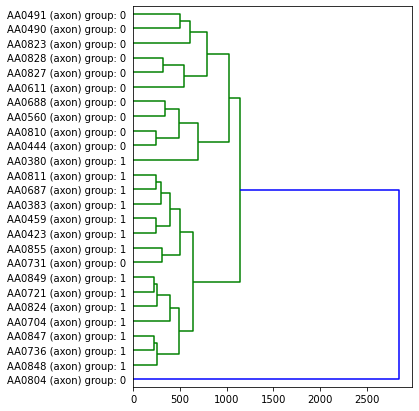

In [17]:
# Perform Hierarchical Clustering on the landscape matrix and plot a dendrogram
# Use Chebyshev distance since it is stable with respect to the Bottleneck Distance
model = AgglomerativeClustering(affinity='chebyshev', linkage='complete', distance_threshold=0, n_clusters=None)
model = model.fit(ls_matrix)
fig, ax = plt.subplots(figsize=(5,7))
plot_dendrogram(model)

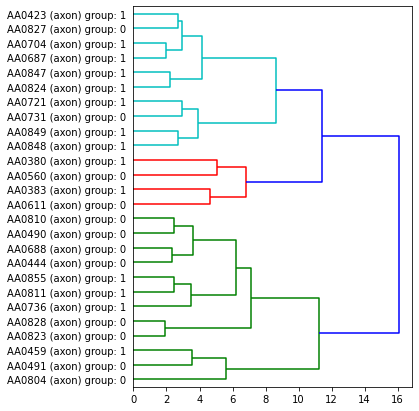

In [18]:
# cluster using morphometrics
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
model = model.fit(scaled_morph_matrix)
fig, ax = plt.subplots(figsize=(5,7))
plot_dendrogram(model)

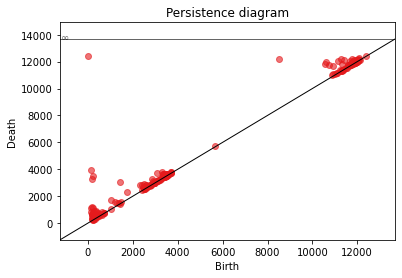

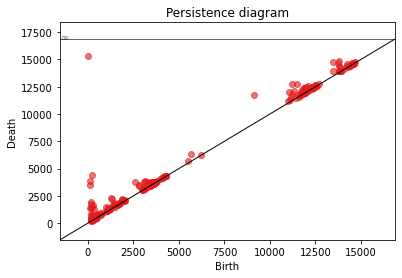

In [11]:
# convert first diagram to required format for gudhi plotter
# (dimension, (birth, death))
for key, pd in diagram_map.items():
    d = []
    for p in pd[0]:
        d.append((0,(p[0], p[1])))
    diagram_map[key][0] = d
gd.plot_persistence_diagram(diagram_map['AA0490'][0])
gd.plot_persistence_diagram(diagram_map['AA0491'][0])

In [12]:
group_stats = GroupedTreeStatistics()
group_stats.addGroup(ij.py.to_java(trees[0:12]), "Group 2")
group_stats.addGroup(ij.py.to_java(trees[12:26]), "Group 3")
target_areas = [AllenUtils.getCompartment("Mammillary body"), AllenUtils.getCompartment("Thalamus")]
group_stats.getBoxPlot("tips", ij.py.to_java(target_areas)).show()

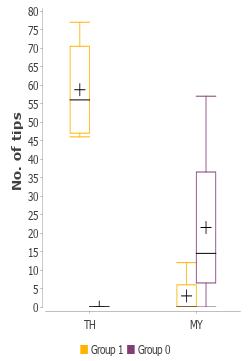

In [13]:
from IPython.display import Image, display
display(Image(filename=r"C:\Users\cam\Desktop\boxplot.png"))